## ⚡ Forecasting Renewable Energy in Germany: A Deep Learning Approach
**🌍 Introduction: The Challenge of the Energiewende**

Germany's ambitious energy transition, the Energiewende, has made it a world leader in renewable energy. However, the increasing reliance on volatile sources like wind and solar power presents a significant challenge for grid stability and energy market management. The unpredictable nature of these sources means that the supply of electricity can fluctuate dramatically, requiring highly accurate forecasts to ensure that supply always meets demand.

This project tackles this challenge head-on by developing and evaluating a suite of advanced deep learning models to forecast hourly renewable energy generation in Germany.

**🎯 Project Goal**

The primary objective of this project is to build, tune, and compare multiple state-of-the-art time series forecasting models to determine the most effective architecture for predicting renewable energy production at different forecast horizons.

This notebook will walk through the entire end-to-end machine learning workflow, from sourcing and processing raw data to a final, rigorous comparison of model performance.

**❓ Key Questions**

This analysis aims to answer the following key questions:

1- How does the performance of a classic LSTM model compare to a modern Transformer architecture for this task?

2- Which model architecture is superior for short-range (1-hour) vs. long-range (12-hour) forecasts?

3- How does the model's performance change when forecasting different energy types (solar vs. wind)?

4- Can we systematically find the best model configuration using automated hyperparameter tuning with Optuna?

**🛠️ Methodology Overview**

* Data Sourcing: Download five years of hourly energy data from the Open Power System Data (OPSD) platform and historical weather data from the Copernicus ERA5 dataset.

* Feature Engineering: Create a rich feature set including time-based cyclical features, lag features, and rolling window statistics.

* Modeling: Implement and train multiple models using PyTorch Lightning, including an LSTM baseline and a custom Transformer.

* Hyperparameter Tuning: Use Optuna to systematically optimize the models for peak performance.

* Evaluation & Analysis: Perform a comprehensive evaluation of all models across different forecasting tasks and horizons, visualizing the final results to draw clear, data-driven conclusions.

# Imports

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import xarray as xr
import glob
from sklearn.preprocessing import StandardScaler
import warnings
import cdsapi
import os
from retrying import retry
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
import math
import optuna
import matplotlib.pyplot as plt

# 1- Preprocessing Functions

In [ ]:
@retry(stop_max_attempt_number=3, wait_fixed=10000)
def download_month(c, year, month, variables, area, filename):
    """A robust function to download a single month of data."""
    print(f"Requesting data from the CDS for {year}-{month}...")
    c.retrieve(
        # --- THE CRITICAL FIX ---
        'reanalysis-era5-single-levels', # Use the main dataset
        {
            'product_type': 'reanalysis',
            'variable': variables,
            'year': year,
            'month': month,
            'day': [f'{d:02d}' for d in range(1, 32)],
            'time': [f'{h:02d}:00' for h in range(24)],
            'area': area,
            'format': 'netcdf',
        },
        filename
    )

def process_weather_data(base_data_folder='data/germany_weather_2015_2020/',
                         opsd_file_path = 'data/Open_Power_System_Data/time_series_60min_singleindex.csv',
                         output_csv_path = 'germany_energy_and_weather_hourly.csv'
                         ):
    """ Process weather data from ERA5 and OPSD, merging them into a single DataFrame. """
    # --- Step 1: Find All Weather Data Files ---
    print("--- Searching for weather data files... ---")

    # Create two separate patterns, one for each file type
    instant_pattern = os.path.join(base_data_folder, '**', '*stepType-instant.nc')
    accum_pattern = os.path.join(base_data_folder, '**', '*stepType-accum.nc')

    # Find all files of each type
    instant_files = sorted(glob.glob(instant_pattern, recursive=True))
    accum_files = sorted(glob.glob(accum_pattern, recursive=True))

    if not instant_files or not accum_files:
        print("Error: Could not find both 'instant' and 'accum' files. Please check the download folder.")
        exit()

    print(f"Found {len(instant_files)} instantaneous and {len(accum_files)} accumulated files.")

    # --- Step 2: Load and Process Each File Type Separately ---
    print("--- Loading and processing file types... ---")

    # Open all instantaneous files together
    ds_instant = xr.open_mfdataset(instant_files, combine="by_coords", engine="netcdf4")
    df_instant = ds_instant.mean(dim=['latitude', 'longitude']).to_dataframe()

    # Open all accumulated files together
    ds_accum = xr.open_mfdataset(accum_files, combine="by_coords", engine="netcdf4")
    df_accum = ds_accum.mean(dim=['latitude', 'longitude']).to_dataframe()

    # --- Step 3: Merge the Two Weather DataFrames ---
    print("--- Merging weather data types... ---")
    # Merge the two dataframes on their shared 'time' index
    df_weather = pd.merge(df_instant, df_accum, left_index=True, right_index=True)


    # --- Step 4: Final Processing of the Combined Weather DataFrame ---
    print("--- Finalizing weather data... ---")

    # Drop metadata columns that came from the NetCDF files
    df_weather.drop(columns=['number', 'expver', 'step'], inplace=True, errors='ignore')

    # Rename columns to be more descriptive
    df_weather.rename(columns={
        't2m': 'temperature_celsius',
        'ssrd': 'solar_radiation',
        'tcc': 'total_cloud_cover',
        'u100': 'wind_u_100m',
        'v100': 'wind_v_100m'
    }, inplace=True)

    # Process the data
    df_weather['temperature_celsius'] = df_weather['temperature_celsius'] - 273.15
    df_weather['wind_speed_100m'] = np.sqrt(df_weather['wind_u_100m']**2 + df_weather['wind_v_100m']**2)
    df_weather.drop(columns=['wind_u_100m', 'wind_v_100m'], inplace=True)

    df_weather.index.name = 'utc_timestamp'
    df_weather = df_weather.tz_localize('UTC')

    print("Weather data processed successfully.")


    # --- Step 5: Load Your OPSD Energy Data ---
    print("\n--- Loading OPSD energy data... ---")
    try:
        df_energy = pd.read_csv(
            opsd_file_path,
            index_col='utc_timestamp',
            parse_dates=True
        )
    except FileNotFoundError:
        print(f"Error: Could not find the OPSD hourly data file at '{opsd_file_path}'.")
        exit()


    # --- Step 6: Merge the Energy and Weather Datasets ---
    print("\n--- Merging energy and weather data... ---")
    df_final = pd.merge(df_energy, df_weather, left_index=True, right_index=True, how='inner')


    # --- Step 7: Final Check and Save ---
    print("\n--- Final Merged DataFrame ---")
    print(f"Final data shape: {df_final.shape}")
    print("Checking for any remaining missing values (top 5)...")
    print(df_final.isnull().sum().sort_values(ascending=False).head())

    df_final.to_csv(output_csv_path)
    print(f"\n✅ Success! Final merged data saved to '{output_csv_path}'")

def create_sequences(data, input_len, output_len, target_col_indices):
    """
    Creates input sequences (X) and output sequences (y) from time series data.

    Args:
        data (pd.DataFrame or np.array): The input data.
        input_len (int): The length of the input sequences (lookback window).
        output_len (int): The length of the output sequences (forecast horizon).
        target_col_indices (list of int): List of column indices for the target variable(s).

    Returns:
        tuple: A tuple containing two NumPy arrays (X, y).
    """
    X_list, y_list = [], []
    data_as_array = data.to_numpy() # Convert dataframe to numpy array for efficiency

    for i in range(len(data_as_array) - input_len - output_len + 1):
        # The input window (all features)
        input_window = data_as_array[i : i + input_len, :]
        X_list.append(input_window)

        # The output window (only the target column(s))
        output_window = data_as_array[i + input_len : i + input_len + output_len, target_col_indices]
        y_list.append(output_window)

    return np.array(X_list), np.array(y_list)

def preprocess_data(file_name='data/Open_Power_System_Data/germany_energy_and_weather_hourly.csv',
                    predict_target='combined', input_length=168, output_length=1, debug=False):
    """
    Loads, cleans, and prepares the German energy dataset for time series forecasting.

    Args:
        file_name (str): Path to the input CSV file.
        predict_target (str): The target to forecast. Must be one of 
                              ['combined', 'solar', 'wind', 'wind_onshore', 'wind_offshore'].
        input_length (int): The number of past time steps to use as input (lookback window).
        output_length (int): The number of future time steps to predict (forecast horizon).
        debug (bool): If True, prints detailed status messages during execution.

    Returns:
        tuple: A tuple containing the prepared PyTorch tensors and the training DataFrame to see how the data looks like:
               (X_train, y_train, X_val, y_val, X_test, y_test, train_df)
    """
    warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

    # --- Step 1: Load Data ---
    
    if debug:
        print(f"--- Starting Preprocessing for Target: '{predict_target}' ---")
    try:
        df = pd.read_csv(file_name, index_col='utc_timestamp', parse_dates=True)
        if debug:
            print(f"--- Step 1: Data Loaded Successfully (Initial Shape: {df.shape}) ---\n")
    except FileNotFoundError:
        print(f"Error: {file_name} not found.")
        return

    de_cols = [
        # --- Target Components (to be summed up into a single target variable) ---
        'DE_solar_generation_actual',
        'DE_wind_onshore_generation_actual',
        'DE_wind_offshore_generation_actual',
        # --- Core Predictors: Load (a key driver) ---
        'DE_load_actual_entsoe_transparency',      # Actual total electricity demand
        'DE_load_forecast_entsoe_transparency',    # Professional day-ahead forecast for demand
        # --- Core Predictors: Capacity & Profile (for normalization and efficiency) ---
        'DE_solar_capacity',
        'DE_wind_onshore_capacity',
        'DE_wind_offshore_capacity',
        'DE_solar_profile',
        'DE_wind_onshore_profile',
        'DE_wind_offshore_profile',
        # --- Advanced Predictors: TSO-level data for more granular signals ---
        'DE_50hertz_solar_generation_actual',
        'DE_50hertz_wind_onshore_generation_actual',
        'DE_amprion_solar_generation_actual',
        'DE_amprion_wind_onshore_generation_actual',
        'DE_tennet_solar_generation_actual',
        'DE_tennet_wind_onshore_generation_actual',
        'DE_tennet_wind_offshore_generation_actual',
        'DE_transnetbw_solar_generation_actual',
        # --- Weather Features (to capture environmental impacts) ---
        'temperature_celsius',
        'solar_radiation',
        'total_cloud_cover',
        'wind_speed_100m'
    ]

    # Create a new dataframe focused on German data
    df_de = df[de_cols].copy()

    # --- Step 2: Filter, Clean, and Interpolate ---

    # Handle missing values using linear interpolation
    if debug:
        print("--- Step 2: Cleaning and Interpolating ---")
        print(f"Missing values before interpolation:\n{df_de.isnull().sum()}")

    df_de.interpolate(method='linear', inplace=True)

    if debug:
        print(f"\nMissing values after interpolation:\n{df_de.isnull().sum()}")
        print(f"Data shape after filtering: {df_de.shape}")
        print("\n")


    # --- Step 3: Feature Engineering ---
    if debug:
        print("--- Step 3: Engineering Time-Based Features ---")

    # Create time-based features from the datetime index
    df_de['hour'] = df_de.index.hour
    df_de['day_of_week'] = df_de.index.dayofweek # Monday=0, Sunday=6
    df_de['month'] = df_de.index.month
    df_de['day_of_year'] = df_de.index.dayofyear

    # Create cyclical features for 'hour' and 'month' to help the model understand their cyclical nature
    df_de['hour_sin'] = np.sin(2 * np.pi * df_de['hour']/24.0)
    df_de['hour_cos'] = np.cos(2 * np.pi * df_de['hour']/24.0)
    df_de['month_sin'] = np.sin(2 * np.pi * (df_de['month']-1)/12.0)
    df_de['month_cos'] = np.cos(2 * np.pi * (df_de['month']-1)/12.0)

    # Drop the original time features that are now encoded
    df_de.drop(['hour', 'month'], axis=1, inplace=True)

    if debug:
        print("New features created. Here's a look at the data:")
        print(df_de.head())
        print("\n")
        print("--- Creating Final Target Variable and Dropping Edge NaNs ---")

    # Create the combined renewable energy target variable
    df_de['DE_VRE_generation_actual'] = df_de['DE_solar_generation_actual'] + \
                                    df_de['DE_wind_onshore_generation_actual'] + \
                                    df_de['DE_wind_offshore_generation_actual']

    # Drop any rows that still contain NaN values (at the start/end of the dataset)
    df_de.dropna(inplace=True)

    if debug:
        print(f"Final data shape after dropping remaining NaNs: {df_de.shape}")
        print(f"\nMissing values after dropping remaining NaNs:\n{df_de.isnull().sum()}")
        print("Data is now 100% clean.")
        print("\n")

    # --- Step 4: Engineering Advanced Features ---
    if debug:
        print("--- Step 4: Engineering Advanced Features ---")
                                    
    # If we use the 15min data, we need to adjust the offsets accordingly.(*4)
    # For 1-hour data, we use 24 for daily and 168 for weekly
    DAY_OFFSET = 24   
    WEEK_OFFSET = DAY_OFFSET * 7

    # Create Lag Features
    df_de['target_lag_1_day'] = df_de['DE_VRE_generation_actual'].shift(DAY_OFFSET)
    df_de['target_lag_1_week'] = df_de['DE_VRE_generation_actual'].shift(WEEK_OFFSET)

    # Create Rolling Window Features
    df_de['target_rolling_mean_24h'] = df_de['DE_VRE_generation_actual'].rolling(window=DAY_OFFSET).mean()
    df_de['target_rolling_std_24h'] = df_de['DE_VRE_generation_actual'].rolling(window=DAY_OFFSET).std()

    # To Prevent data leakage, we choose the columns to drop based on the target variable
    if predict_target == 'combined':
        columns_to_drop =[
                            'DE_solar_generation_actual',
                            'DE_wind_onshore_generation_actual',
                            'DE_wind_offshore_generation_actual',
                            'DE_50hertz_solar_generation_actual',
                            'DE_50hertz_wind_onshore_generation_actual',
                            'DE_amprion_solar_generation_actual',
                            'DE_amprion_wind_onshore_generation_actual',
                            'DE_tennet_solar_generation_actual',
                            'DE_tennet_wind_onshore_generation_actual',
                            'DE_tennet_wind_offshore_generation_actual',
                            'DE_transnetbw_solar_generation_actual',
                            'DE_solar_profile',
                            'DE_wind_onshore_profile',
                            'DE_wind_offshore_profile',
                            ]
        # Reorder columns to have the target first for easier indexing
        feature_order = ['DE_VRE_generation_actual'] + [col for col in df_de.columns if col != 'DE_VRE_generation_actual']
        df_de = df_de[feature_order] 
        
    elif predict_target == 'solar':
        columns_to_drop =[
                    'DE_wind_onshore_generation_actual',
                    'DE_wind_offshore_generation_actual',
                    'DE_50hertz_solar_generation_actual',
                    'DE_50hertz_wind_onshore_generation_actual',
                    'DE_amprion_solar_generation_actual',
                    'DE_amprion_wind_onshore_generation_actual',
                    'DE_tennet_solar_generation_actual',
                    'DE_tennet_wind_onshore_generation_actual',
                    'DE_tennet_wind_offshore_generation_actual',
                    'DE_transnetbw_solar_generation_actual',
                    'DE_solar_profile',
                    'wind_speed_100m', # we remove this for solar because of irrelevance to solar generation
                    'DE_VRE_generation_actual' 
                    ]
        # Reorder columns to have the target first for easier indexing
        feature_order = ['DE_solar_generation_actual'] + [col for col in df_de.columns if col != 'DE_solar_generation_actual']
        df_de = df_de[feature_order] 
        
    elif predict_target == 'wind':
        columns_to_drop =[
                    'DE_solar_generation_actual',
                    'DE_wind_onshore_generation_actual',
                    'DE_wind_offshore_generation_actual',
                    'DE_50hertz_solar_generation_actual',
                    'DE_50hertz_wind_onshore_generation_actual',
                    'DE_amprion_solar_generation_actual',
                    'DE_amprion_wind_onshore_generation_actual',
                    'DE_tennet_solar_generation_actual',
                    'DE_tennet_wind_onshore_generation_actual',
                    'DE_tennet_wind_offshore_generation_actual',
                    'DE_transnetbw_solar_generation_actual',
                    'DE_solar_profile',
                    'DE_VRE_generation_actual',
                    'DE_wind_onshore_profile',
                    'DE_wind_offshore_profile', 
                    ]
         # Combine onshore and offshore wind generation into a single feature
        df_de['DE_wind_combined_generation_actual'] = df_de['DE_wind_onshore_generation_actual'] + \
                                                    df_de['DE_wind_offshore_generation_actual']
        
        feature_order = ['DE_wind_combined_generation_actual'] + [col for col in df_de.columns if col != 'DE_wind_combined_generation_actual']
        df_de = df_de[feature_order] 
        
        
    elif predict_target == 'wind_offshore':
        columns_to_drop =[
                    'DE_solar_generation_actual',
                    'DE_wind_onshore_generation_actual',
                    'DE_50hertz_solar_generation_actual',
                    'DE_50hertz_wind_onshore_generation_actual',
                    'DE_amprion_solar_generation_actual',
                    'DE_amprion_wind_onshore_generation_actual',
                    'DE_tennet_solar_generation_actual',
                    'DE_tennet_wind_onshore_generation_actual',
                    'DE_tennet_wind_offshore_generation_actual',
                    'DE_transnetbw_solar_generation_actual',
                    'DE_solar_profile',
                    'DE_VRE_generation_actual',
                    'DE_wind_onshore_profile',
                    'DE_wind_offshore_profile', 
                    ]
        
        
        feature_order = ['DE_wind_offshore_generation_actual'] + [col for col in df_de.columns if col != 'DE_wind_offshore_generation_actual']
        df_de = df_de[feature_order] 
        
        
    elif predict_target == 'wind_onshore':
        columns_to_drop =[
                    'DE_solar_generation_actual',
                    'DE_50hertz_solar_generation_actual',
                    'DE_50hertz_wind_onshore_generation_actual',
                    'DE_amprion_solar_generation_actual',
                    'DE_amprion_wind_onshore_generation_actual',
                    'DE_tennet_solar_generation_actual',
                    'DE_tennet_wind_onshore_generation_actual',
                    'DE_tennet_wind_offshore_generation_actual',
                    'DE_transnetbw_solar_generation_actual',
                    'DE_solar_profile',
                    'DE_VRE_generation_actual',
                    'DE_wind_onshore_profile',
                    'DE_wind_offshore_profile', 
                    ]
        
        
        feature_order = ['DE_wind_onshore_generation_actual'] + [col for col in df_de.columns if col != 'DE_wind_onshore_generation_actual']
        df_de = df_de[feature_order] 
        
    df_de.drop(columns=columns_to_drop, axis="columns", inplace=True)

    # IMPORTANT: Clean up NaNs created by shift/rolling operations
    # The first week of data will now be NaN, so we must drop it.
    df_de.dropna(inplace=True)

    if debug:
        print("New features created. Here's the updated data head:")
        print(df_de.head())
        print(f"\nNew data shape after adding features and dropping NaNs: {df_de.shape}")


    # --- Step 5: Data Splitting ---
    if debug:
        print("--- Step 5: Splitting Data Chronologically ---")

    # Training set is everything before 2018.
    train_df = df_de.loc[df_de.index < '2018-01-01'].copy()
    # Validation set is the full year of 2018.
    val_df = df_de.loc[(df_de.index >= '2018-01-01') & (df_de.index < '2019-01-01')].copy()
    # Test set is the full year of 2019 for robust evaluation.
    test_df = df_de.loc[(df_de.index >= '2019-01-01') & (df_de.index < '2020-01-01')].copy()

    if debug:
        print(f"Training set shape:   {train_df.shape}")
        print(f"Validation set shape: {val_df.shape}")
        print(f"Test set shape:       {test_df.shape}")


    # --- Step 6: Scaling the Data ---
    if debug:
        print("--- Step 6: Scaling Features ---")

    # Define the features to be scaled (all columns in our case)
    features_to_scale = train_df.columns

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # CRITICAL: Fit the scaler ONLY on the training data
    scaler.fit(train_df[features_to_scale])

    # Transform the training, validation, and test sets using the fitted scaler
    train_df[features_to_scale] = scaler.transform(train_df[features_to_scale])
    val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
    test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

    if debug:
        print("Data scaling complete. Note: Scaler was fit ONLY on training data to prevent data leakage.")
        print("\n")
    # --- Final Confirmation ---
        print("--- Preprocessing Complete ---")
        print("The data is now fully preprocessed and split into train_df, val_df, and test_df.")
        print("You are ready to use these dataframes to create sequences for your Transformer model.")
    
    
    # --- Define Parameters ---
    INPUT_LENGTH = input_length   # in hours 
    OUTPUT_LENGTH = output_length  # in hours 

    # The target column 'DE_VRE_generation_actual' is the first column (index 0)
    TARGET_COLUMN_INDICES = [0]

    # --- Apply the function to your datasets ---
    if debug:
        print("Creating sequences for training, validation, and test sets...")

    X_train, y_train = create_sequences(train_df, INPUT_LENGTH, OUTPUT_LENGTH, TARGET_COLUMN_INDICES)
    X_val, y_val = create_sequences(val_df, INPUT_LENGTH, OUTPUT_LENGTH, TARGET_COLUMN_INDICES)
    X_test, y_test = create_sequences(test_df, INPUT_LENGTH, OUTPUT_LENGTH, TARGET_COLUMN_INDICES)
    
    if debug:
        print("Sequence creation complete.")
        print("\n--- Data Shapes ---")
        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print("-" * 20)
        print(f"X_val shape: {X_val.shape}")
        print(f"y_val shape: {y_val.shape}")
        print("-" * 20)
        print(f"X_test shape: {X_test.shape}")
        print(f"y_test shape: {y_test.shape}")

    # --- Convert NumPy arrays to PyTorch Tensors ---
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Squeeze the target's last dimension for the loss function
    # The reason we do this is to make the shape of our true labels
    # (y_train) perfectly match the shape of our model's predictions.
    y_train, y_val, y_test = y_train.squeeze(), y_val.squeeze(), y_test.squeeze()
    
    if debug:
        print(f"X_train tensor shape: {X_train.shape}")
        print(f"y_train tensor shape: {y_train.shape}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test , train_df


In [ ]:
# =================================================================================================================
#                  UNCOMMENT THIS SECTION TO DOWNLOAD WEATHER DATA AND TO PROCESS THE WEATHER DATA
# =================================================================================================================
# --- Initialize the CDS API client to download the weather data ---
# c = cdsapi.Client()
# # --- Parameters (no changes here) ---
# years_to_download = [str(year) for year in range(2015, 2020)]
# months_to_download = [f'{m:02d}' for m in range(1, 13)]
# data_folder = 'data/germany_weather_2015_2020/'
# germany_area = [55.5, 5.5, 47.0, 15.5] 
# variables_to_download = [
#     '2m_temperature',
#     'total_cloud_cover',
#     'surface_solar_radiation_downwards',
#     '100m_u_component_of_wind',
#     '100m_v_component_of_wind',
# ]

# os.makedirs(data_folder, exist_ok=True)

# # Loop through and download
# for year in years_to_download:
#     for month in months_to_download:
#         output_filename = os.path.join(data_folder, f"germany_weather_{year}-{month}.nc")
        
#         if os.path.exists(output_filename):
#             print(f"File '{output_filename}' already exists. Skipping.")
#             continue

#         try:
#             download_month(c, year, month, variables_to_download, germany_area, output_filename)
#             print(f"✅ Successfully downloaded {output_filename}")
#         except Exception as e:
#             print(f"❌ Failed to download for {year}-{month}. Error: {e}")

# print("\nAll download tasks are complete.")

# print("\n--- Processing Weather Data ---")
# process_weather_data()
# =================================================================================================================
#                  
# =================================================================================================================

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(file_name="data/Open_Power_System_Data/germany_energy_and_weather_hourly.csv",
                                                                           predict_target='combined', debug=True)

--- Starting Preprocessing for Target: 'combined' ---
--- Step 1: Data Loaded Successfully (Initial Shape: (43824, 307)) ---

--- Step 2: Cleaning and Interpolating ---
Missing values before interpolation:
DE_solar_generation_actual                   103
DE_wind_onshore_generation_actual             72
DE_wind_offshore_generation_actual            74
DE_load_actual_entsoe_transparency             0
DE_load_forecast_entsoe_transparency          24
DE_solar_capacity                             25
DE_wind_onshore_capacity                      25
DE_wind_offshore_capacity                     25
DE_solar_profile                             128
DE_wind_onshore_profile                       97
DE_wind_offshore_profile                      99
DE_50hertz_solar_generation_actual             7
DE_50hertz_wind_onshore_generation_actual      0
DE_amprion_solar_generation_actual             7
DE_amprion_wind_onshore_generation_actual      0
DE_tennet_solar_generation_actual              7
DE_tennet_

In [16]:
train_df.head()

,DE_VRE_generation_actual,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_solar_capacity,DE_wind_onshore_capacity,DE_wind_offshore_capacity,temperature_celsius,solar_radiation,total_cloud_cover,wind_speed_100m,day_of_week,day_of_year,hour_sin,hour_cos,month_sin,month_cos,target_lag_1_day,target_lag_1_week,target_rolling_mean_24h,target_rolling_std_24h
utc_timestamp,,,,,,,,,,,,,,,,,,,,
2015-01-08 07:00:00+00:00,0.478125,1.301045,0.637037,-1.582445,-1.471856,-2.487991,-1.037208,-0.689389,1.410295,1.722304,-0.002756,-1.683051,1.366258,-0.365793,0.004278,1.433954,-0.655841,-0.375631,-0.101845,-0.807914
2015-01-08 08:00:00+00:00,0.535953,1.304027,0.711322,-1.582445,-1.471856,-2.487991,-0.988862,-0.657865,1.422489,1.692562,-0.002756,-1.683051,1.224978,-0.706874,0.004278,1.433954,-0.641194,-0.317802,-0.034430,-0.809021
2015-01-08 09:00:00+00:00,0.597078,1.391988,0.799208,-1.582445,-1.471856,-2.487991,-0.914832,-0.554077,1.417941,1.697302,-0.002756,-1.683051,1.000233,-0.999767,0.004278,1.433954,-0.529083,-0.111587,0.030077,-0.793981
2015-01-08 10:00:00+00:00,0.650288,1.506388,0.949557,-1.582445,-1.471856,-2.487991,-0.824959,-0.436999,1.401262,1.466946,-0.002756,-1.683051,0.707339,-1.224512,0.004278,1.433954,-0.379087,0.119176,0.089060,-0.759288
2015-01-08 11:00:00+00:00,0.611590,1.439497,0.910322,-1.582445,-1.471856,-2.487991,-0.750671,-0.370182,1.387760,1.538410,-0.002756,-1.683051,0.366258,-1.365793,0.004278,1.433954,-0.274684,0.290229,0.139864,-0.732358


# 2- Defining the models 

In [ ]:
# ===============================================================================
#                   PyTorch Dataset and Lightning DataModule
#     These classes handle the loading and preparation of data for the model.
# ===============================================================================
class TimeSeriesDataset(Dataset):
    """
    A simple PyTorch Dataset for time series data.
    It takes the pre-sequenced input (X) and target (y) arrays and serves
    them up sample by sample.
    """
    def __init__(self, X, y):
        """
        Args:
            X (np.array or torch.Tensor): The input sequences. 
                                          Shape: (num_samples, input_length, num_features)
            y (np.array or torch.Tensor): The target sequences.
                                          Shape: (num_samples, output_length) or (num_samples,)
        """
        self.X = X
        self.y = y

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieves a single sample (input and target) from the dataset.
        
        Args:
            idx (int): The index of the sample to retrieve.
            
        Returns:
            tuple: A tuple containing the input tensor and the target tensor.
        """
        return self.X[idx], self.y[idx]

class TimeSeriesDataModule(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule to encapsulate all data-related steps.
    This module handles the creation of Datasets and DataLoaders for the
    training, validation, and testing sets.
    """
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64, num_workers=0):
        """
        Args:
            X_train, y_train: Training data and targets.
            X_val, y_val: Validation data and targets.
            X_test, y_test: Test data and targets.
            batch_size (int): The number of samples per batch.
            num_workers (int): The number of subprocesses to use for data loading.
        """
        super().__init__()
        # Store the raw data arrays
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        """
        Assigns the datasets for each stage (fit, validate, test).
        This is called on every GPU in a distributed setup.
        """
        self.train_dataset = TimeSeriesDataset(self.X_train, self.y_train)
        self.val_dataset = TimeSeriesDataset(self.X_val, self.y_val)
        self.test_dataset = TimeSeriesDataset(self.X_test, self.y_test)

    def train_dataloader(self):
        """Returns the DataLoader for the training set."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        """Returns the DataLoader for the validation set."""
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        """Returns the DataLoader for the test set."""
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [ ]:
# ===============================================================================
#                       PyTorch Lightning Model Definitions 
# ===============================================================================

class LSTMBaselineSystem(pl.LightningModule):
    """
    A PyTorch Lightning module for the LSTM baseline model.
    This class encapsulates the model architecture, the forward pass logic,
    and the training, validation, and test steps.
    """
    def __init__(self, input_features, hidden_size, output_features, learning_rate=1e-4, weight_decay=1e-3, dropout=0.2):
        """
        Args:
            input_features (int): The number of features in the input data.
            hidden_size (int): The number of features in the LSTM hidden state.
            output_features (int): The number of output steps to predict (forecast horizon).
            learning_rate (float): The learning rate for the optimizer.
            weight_decay (float): The weight decay (L2 regularization) for the optimizer.
            dropout (float): The dropout rate for regularization.
        """
        super().__init__()
        # This saves all hyperparameters to self.hparams, making them accessible later
        self.save_hyperparameters()

        # --- Model Architecture ---
        # LSTM layer that processes the input sequence
        self.lstm = nn.LSTM(
            input_size=input_features,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True, # Expects input tensors of shape (batch, seq, feature)
        )
        
        # Dropout layer for regularization after the LSTM
        self.dropout = nn.Dropout(dropout) 
        
        # Final fully-connected layer to map the LSTM output to the desired forecast horizon
        self.linear = nn.Linear(hidden_size, output_features)
        
        # The loss function used for training
        self.loss_fn = nn.L1Loss() # Mean Absolute Error

    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): The input tensor. Shape: (batch, seq_len, features)
            
        Returns:
            torch.Tensor: The model's prediction. Shape: (batch, output_len)
        """
        # Pass the input through the LSTM layer
        # We only care about the output, not the final hidden and cell states (_)
        lstm_out, _ = self.lstm(x)
        
        # We take the output of the very last time step from the LSTM sequence
        last_time_step_out = lstm_out[:, -1, :]
        
        # Apply dropout for regularization
        dropout_out = self.dropout(last_time_step_out)
        
        # Pass the result through the final linear layer to get the prediction
        return self.linear(dropout_out)

    def _get_extra_metrics(self, y_hat, y):
        """
        Helper function to calculate additional evaluation metrics (sMAPE and Accuracy).
        
        Args:
            y_hat (torch.Tensor): The model's predictions.
            y (torch.Tensor): The true target values.
            
        Returns:
            tuple: A tuple containing the sMAPE and accuracy values.
        """
        # sMAPE (Symmetric Mean Absolute Percentage Error) - A robust percentage error
        epsilon = 1e-8
        numerator = torch.abs(y_hat - y)
        denominator = (torch.abs(y) + torch.abs(y_hat)) / 2 + epsilon
        smape = torch.mean(numerator / denominator) * 100
        
        # Threshold Accuracy - Percentage of predictions within a 5% tolerance
        relative_tolerance = 0.05
        absolute_tolerance = 0.01
        absolute_error = torch.abs(y_hat - y)
        mask = torch.abs(y) > epsilon
        relative_error = torch.zeros_like(y)
        if torch.any(mask):
            relative_error[mask] = absolute_error[mask] / torch.abs(y[mask])
        
        accurate_predictions = (relative_error < relative_tolerance) | (absolute_error < absolute_tolerance)
        accuracy = torch.mean(accurate_predictions.float()) * 100

        return smape, accuracy

    def training_step(self, batch, batch_idx):
        """Defines a single training step."""
        x, y = batch
        y_hat_raw = self(x)
        
        # Squeeze the output if necessary to match the label's shape (for single-step forecasts)
        y_hat = y_hat_raw.squeeze() if y_hat_raw.ndim > y.ndim else y_hat_raw
        
        # Calculate the loss
        loss = self.loss_fn(y_hat, y)
        
        # Log the training loss for monitoring
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """Defines a single validation step."""
        x, y = batch
        y_hat_raw = self(x)
        
        # Squeeze the output to match the label's shape
        y_hat = y_hat_raw.squeeze() if y_hat_raw.ndim > y.ndim else y_hat_raw
        
        # Calculate loss and all extra metrics
        loss = self.loss_fn(y_hat, y)
        smape, acc = self._get_extra_metrics(y_hat, y)
        
        # Log all validation metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_smape', smape, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        """Defines a single test step."""
        x, y = batch
        y_hat_raw = self(x)

        # Squeeze the output to match the label's shape
        y_hat = y_hat_raw.squeeze() if y_hat_raw.ndim > y.ndim else y_hat_raw
        
        # Calculate loss and all extra metrics for the final report
        loss = self.loss_fn(y_hat, y)
        smape, acc = self._get_extra_metrics(y_hat, y)
        self.log('test_mae', loss)
        self.log('test_smape', smape)
        self.log('test_acc', acc)

    def configure_optimizers(self):
        """Configures the optimizer and learning rate scheduler."""
        # AdamW is a robust optimizer with weight decay
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.hparams.learning_rate, 
            weight_decay=self.hparams.weight_decay
        )
        
        # CosineAnnealingLR smoothly decreases the learning rate over epochs
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs, # The number of epochs to complete one cosine cycle
            eta_min=1e-6                  # The minimum learning rate
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }      

class PositionalEncoding(nn.Module):
    """
    Injects positional information into the input embeddings.
    Since Transformers do not have a built-in sense of sequence order, this
    module adds a unique encoding to each position in the sequence, allowing
    the model to understand the order of the patches.
    """
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        """
        Args:
            d_model (int): The dimensionality of the model's embeddings.
            dropout (float): The dropout rate.
            max_len (int): The maximum possible sequence length.
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create the positional encoding matrix using sine and cosine functions
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register 'pe' as a buffer so it's part of the model's state but not a parameter
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        """
        Adds positional encoding to the input tensor.
        
        Args:
            x (torch.Tensor): The input tensor. Shape: (batch_size, seq_len, d_model)
        """
        # Add the positional encoding, slicing it to the input's sequence length.
        # It will be broadcasted across the batch dimension.
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerSystem(pl.LightningModule):
    """
    Base Transformer model inspired by PatchTST.
    This version uses a "feature-mixing" approach where all features within a patch
    are flattened together before being fed into the model. The prediction head
    is a simple flattening of the encoder output.
    This was the best-performing model in the experiments.
    """
    def __init__(self, 
                 input_len: int, patch_len: int, num_features: int, d_model: int, 
                 nhead: int, num_encoder_layers: int, dim_feedforward: int,
                 output_len: int, dropout: float = 0.1, learning_rate: float = 1e-4):
        super().__init__()
        if input_len % patch_len != 0:
            raise ValueError("input_len must be divisible by patch_len for this model version.")
        self.save_hyperparameters()
        
        # --- Model Architecture ---
        # 1. Patching and Embedding
        num_patches = input_len // patch_len
        self.input_projection = nn.Linear(patch_len * num_features, d_model)
        
        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=num_patches)
        
        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # 4. Prediction Head (Simple Flattening)
        self.prediction_head = nn.Linear(num_patches * d_model, output_len)
        
        # 5. Loss Function
        self.loss_fn = nn.L1Loss() # Mean Absolute Error

    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor. Shape: (batch_size, input_len, num_features)
        
        Returns:
            torch.Tensor: Prediction tensor. Shape: (batch_size, output_len)
        """
        batch_size = x.shape[0]
        num_patches = self.hparams.input_len // self.hparams.patch_len
        
        # 1. Patching: Reshape into patches, mixing features together
        patches = x.reshape(batch_size, num_patches, self.hparams.patch_len * self.hparams.num_features)
        
        # 2. Embedding: Project patches to the model's dimension
        patches_embedded = self.input_projection(patches)
        
        # 3. Add Positional Encoding
        pos_encoded = self.pos_encoder(patches_embedded)
        
        # 4. Pass through Transformer Encoder
        encoder_out = self.transformer_encoder(pos_encoded)
        
        # 5. Prediction: Flatten the encoder output and pass through the final layer
        flattened_out = encoder_out.reshape(batch_size, -1)
        predictions = self.prediction_head(flattened_out)
        
        return predictions
        
    # The _get_extra_metrics, training_step, validation_step, and configure_optimizers
    # methods are identical to the LSTMBaselineSystem and are thus inherited conceptually.
    # For a standalone script, you would copy them here.
    def _get_extra_metrics(self, y_hat, y):
        epsilon = 1e-8
        numerator = torch.abs(y_hat - y)
        denominator = (torch.abs(y) + torch.abs(y_hat)) / 2 + epsilon
        smape = torch.mean(numerator / denominator) * 100
        absolute_error = torch.abs(y_hat - y)
        mask = torch.abs(y) > epsilon
        relative_error = torch.zeros_like(y)
        if torch.any(mask):
            relative_error[mask] = absolute_error[mask] / torch.abs(y[mask])
        accurate_predictions = (relative_error < 0.05) | (absolute_error < 0.01)
        accuracy = torch.mean(accurate_predictions.float()) * 100
        return smape, accuracy

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat_raw = self(x)
        if y_hat_raw.ndim > y.ndim:
            y_hat = y_hat_raw.squeeze(-1)
        else:
            y_hat = y_hat_raw
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat_raw = self(x)
        if y_hat_raw.ndim > y.ndim:
            y_hat = y_hat_raw.squeeze(-1)
        else:
            y_hat = y_hat_raw
        loss = self.loss_fn(y_hat, y)
        smape, acc = self._get_extra_metrics(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_smape', smape, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": lr_scheduler, "monitor": "val_loss"}}

class TransformerSystem2(pl.LightningModule):
    """
    Experimental Transformer model using a "Channel-Independent" patching strategy.
    Each feature (channel) is treated as its own time series, patched independently,
    and then all patch embeddings are combined into a long sequence for the encoder.
    """
    def __init__(self, input_len: int, patch_len: int, num_features: int, d_model: int, 
                 nhead: int, num_encoder_layers: int, dim_feedforward: int,
                 output_len: int, dropout: float = 0.1, learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.patch_len = patch_len
        num_patches = input_len // patch_len
        
        # --- Model Architecture ---
        # 1. Patching and Embedding (Channel-Independent)
        self.input_projection = nn.Linear(self.patch_len, d_model)
        
        # 2. Positional Encoding (for a longer sequence)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=(num_patches * num_features))
        
        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # 4. Prediction Head
        self.prediction_head = nn.Linear((num_patches * num_features) * d_model, output_len)
        
        # 5. Loss Function
        self.loss_fn = nn.L1Loss()

    def forward(self, x):
        """
        Defines the forward pass for the channel-independent model.
        """
        batch_size = x.shape[0]
        x = x.permute(0, 2, 1)
        patches = x.unfold(dimension=-1, size=self.patch_len, step=self.patch_len)
        patches_embedded = self.input_projection(patches)
        transformer_input = patches_embedded.reshape(batch_size, -1, self.hparams.d_model)
        pos_encoded = self.pos_encoder(transformer_input)
        encoder_out = self.transformer_encoder(pos_encoded)
        flattened_out = encoder_out.reshape(batch_size, -1)
        predictions = self.prediction_head(flattened_out)
        return predictions

    def _get_extra_metrics(self, y_hat, y):
        epsilon = 1e-8
        numerator = torch.abs(y_hat - y)
        denominator = (torch.abs(y) + torch.abs(y_hat)) / 2 + epsilon
        smape = torch.mean(numerator / denominator) * 100
        absolute_error = torch.abs(y_hat - y)
        mask = torch.abs(y) > epsilon
        relative_error = torch.zeros_like(y)
        if torch.any(mask):
            relative_error[mask] = absolute_error[mask] / torch.abs(y[mask])
        accurate_predictions = (relative_error < 0.05) | (absolute_error < 0.01)
        accuracy = torch.mean(accurate_predictions.float()) * 100
        return smape, accuracy

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat_raw = self(x)
        if y_hat_raw.ndim > y.ndim:
            y_hat = y_hat_raw.squeeze(-1)
        else:
            y_hat = y_hat_raw
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat_raw = self(x)
        if y_hat_raw.ndim > y.ndim:
            y_hat = y_hat_raw.squeeze(-1)
        else:
            y_hat = y_hat_raw
        loss = self.loss_fn(y_hat, y)
        smape, acc = self._get_extra_metrics(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_smape', smape, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": lr_scheduler, "monitor": "val_loss"}}
    
class TransformerSystem3(pl.LightningModule):
    """
    Experimental Transformer model using the base "feature-mixing" patching but with
    a more sophisticated, two-stage prediction head.
    """
    def __init__(self, 
                 input_len: int, patch_len: int, num_features: int, d_model: int, 
                 nhead: int, num_encoder_layers: int, dim_feedforward: int,
                 output_len: int, dropout: float = 0.1, learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # --- Model Architecture ---
        # 1. Patching and Embedding (Base Version)
        num_patches = input_len // patch_len
        self.input_projection = nn.Linear(patch_len * num_features, d_model)
        
        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=num_patches)

        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # 4. Prediction Head (Sophisticated Two-Stage)
        self.head_linear1 = nn.Linear(d_model, 1)
        self.head_flatten = nn.Flatten(start_dim=1)
        self.head_linear2 = nn.Linear(num_patches, output_len)
        
        # 5. Loss Function
        self.loss_fn = nn.L1Loss()

    def forward(self, x):
        """
        Defines the forward pass for the model with the sophisticated head.
        """
        batch_size = x.shape[0]
        
        # 1. Patching and Embedding (Base Version)
        num_patches = self.hparams.input_len // self.hparams.patch_len
        patches = x.reshape(batch_size, num_patches, self.hparams.patch_len * self.hparams.num_features)
        patches_embedded = self.input_projection(patches)
        
        # 2. Encode
        pos_encoded = self.pos_encoder(patches_embedded)
        encoder_out = self.transformer_encoder(pos_encoded)
        
        # 3. Predict using the two-stage head
        x = self.head_linear1(encoder_out)
        x = self.head_flatten(x)
        predictions = self.head_linear2(x)
        
        return predictions

    def _get_extra_metrics(self, y_hat, y):
        epsilon = 1e-8
        numerator = torch.abs(y_hat - y)
        denominator = (torch.abs(y) + torch.abs(y_hat)) / 2 + epsilon
        smape = torch.mean(numerator / denominator) * 100
        absolute_error = torch.abs(y_hat - y)
        mask = torch.abs(y) > epsilon
        relative_error = torch.zeros_like(y)
        if torch.any(mask):
            relative_error[mask] = absolute_error[mask] / torch.abs(y[mask])
        accurate_predictions = (relative_error < 0.05) | (absolute_error < 0.01)
        accuracy = torch.mean(accurate_predictions.float()) * 100
        return smape, accuracy

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat_raw = self(x)
        if y_hat_raw.ndim > y.ndim:
            y_hat = y_hat_raw.squeeze(-1)
        else:
            y_hat = y_hat_raw
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat_raw = self(x)
        if y_hat_raw.ndim > y.ndim:
            y_hat = y_hat_raw.squeeze(-1)
        else:
            y_hat = y_hat_raw
        loss = self.loss_fn(y_hat, y)
        smape, acc = self._get_extra_metrics(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_smape', smape, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": lr_scheduler, "monitor": "val_loss"}}

In [ ]:
# ===============================================================================
#                      PyTorch Lightning Training Functions 
# ===============================================================================
    
def train_lstm_baseline(X_train, y_train, X_val, y_val, X_test, y_test, exp_name):
    """
    Initializes, trains, and saves an LSTM baseline model.

    This function encapsulates the entire training pipeline for the LSTM model,
    including data module setup, model instantiation with best-found hyperparameters,
    and the configuration of callbacks for early stopping, checkpointing, and logging.

    Args:
        X_train, y_train: Training data and targets (as PyTorch tensors).
        X_val, y_val: Validation data and targets.
        X_test, y_test: Test data and targets.
        exp_name (str): A unique name for the experiment. Used for naming log files
                        and model checkpoints to keep results organized.
    """
    # Set a seed for reproducibility
    pl.seed_everything(42)

    # Determine the number of input and output features from the data shapes
    NUM_FEATURES = X_train.shape[2]
    OUT_FEATURES = 1 if y_train.ndim == 1 else y_train.shape[1]
    
    # Instantiate the DataModule
    data_module = TimeSeriesDataModule(X_train, y_train, X_val, y_val, X_test, y_test)

    # Instantiate the LightningModule with the best hyperparameters found via Optuna
    model = LSTMBaselineSystem(
        input_features=NUM_FEATURES,
        hidden_size=128,
        output_features=OUT_FEATURES,
        learning_rate=0.0011412674740790517,
        weight_decay=6.164039105250974e-06,
        dropout=0.1758228113490677
    )

    # --- Configure Callbacks ---
    # Stop training early if the validation loss stops improving
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True, mode='min')
    
    # Save the best version of the model based on validation loss
    model_checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints',
        filename=f'baseline-lstm-best-model-{{epoch:02d}}-{{val_loss:.4f}}-{exp_name}',
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )

    # Log all metrics to a CSV file for later analysis and plotting
    csv_logger = CSVLogger(save_dir="lightning_logs", name="lstm_logs", version=exp_name)

    # --- Configure the Trainer ---
    trainer = pl.Trainer(
        max_epochs=50,
        logger=csv_logger,
        callbacks=[early_stopping_callback, model_checkpoint_callback],
        accelerator='auto' # Automatically uses GPU if available
    )

    # --- Start Training ---
    trainer.fit(model, datamodule=data_module)

def train_transformer_system(X_train, y_train, X_val, y_val, X_test, y_test,
                             INPUT_LENGTH=168, OUTPUT_LENGTH=6, exp_name='', model_name='TransformerSystem'):
    """
    Initializes, trains, and saves a specified Transformer model.

    This function acts as a flexible trainer for the different Transformer architectures
    developed in this project. It selects the model based on `model_name` and uses
    the best-found hyperparameters for that architecture.

    Args:
        X_train, y_train: Training data and targets (as PyTorch tensors).
        X_val, y_val: Validation data and targets.
        X_test, y_test: Test data and targets.
        INPUT_LENGTH (int): The length of the input sequence (lookback window).
        OUTPUT_LENGTH (int): The length of the output sequence (forecast horizon).
        exp_name (str): A unique name for the experiment for logging and checkpoints.
        model_name (str): The name of the Transformer class to train. Must be one of
                          ['TransformerSystem', 'TransformerSystem2', 'TransformerSystem3'].
    """
    # Set a seed for reproducibility
    pl.seed_everything(42)
    
    # Determine the number of input features from the data shape
    NUM_FEATURES = X_train.shape[2] 
    
    # Instantiate the DataModule
    data_module = TimeSeriesDataModule(X_train, y_train, X_val, y_val, X_test, y_test)

    # --- Select and Instantiate the Model ---
    # This block selects the correct Transformer class based on the model_name
    # and initializes it with the best hyperparameters found via Optuna.
    if model_name == 'TransformerSystem':
        model = TransformerSystem(
            input_len=INPUT_LENGTH,
            patch_len=12,
            num_features=NUM_FEATURES,
            d_model=64,
            nhead=8,
            num_encoder_layers=5,
            dim_feedforward=512,
            dropout=0.24731555867746352,
            output_len=OUTPUT_LENGTH,
            learning_rate=0.00016370747430335437
        )
    elif model_name == 'TransformerSystem2':
        # Note: Hyperparameters for experimental models would be tuned separately
        model = TransformerSystem2(
            input_len=INPUT_LENGTH,
            patch_len=12,
            num_features=NUM_FEATURES,
            d_model=64,
            nhead=8,
            num_encoder_layers=5,
            dim_feedforward=512,
            dropout=0.24731555867746352,
            output_len=OUTPUT_LENGTH,
            learning_rate=0.00016370747430335437
        )
    elif model_name == 'TransformerSystem3':
        # Note: Hyperparameters for experimental models would be tuned separately
        model = TransformerSystem3(
            input_len=INPUT_LENGTH,
            patch_len=12,
            num_features=NUM_FEATURES,
            d_model=64,
            nhead=8,
            num_encoder_layers=5,
            dim_feedforward=512,
            dropout=0.24731555867746352,
            output_len=OUTPUT_LENGTH,
            learning_rate=0.00016370747430335437
        )
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    
    # --- Configure Callbacks ---
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True, mode='min')
    
    model_checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints',
        filename=f'transformer-best-model-{{epoch:02d}}-{{val_loss:.4f}}-{exp_name}',
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )

    csv_logger = CSVLogger(save_dir="lightning_logs", name="transformer_logs", version=exp_name)

    # --- Configure the Trainer ---
    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[early_stopping_callback, model_checkpoint_callback],
        logger=csv_logger,
        accelerator='auto'
    )

    # --- Start Training ---
    trainer.fit(model, datamodule=data_module)


# 2- Using Optuna to find the optimal hyperparameters

In [ ]:
class ManualPruningCallback(Callback):
    """
    A PyTorch Lightning Callback that connects to an Optuna trial to enable pruning.
    
    This callback is a robust alternative to the official PyTorchLightningPruningCallback,
    avoiding potential version compatibility issues. It monitors a specified metric
    (e.g., 'val_loss') at the end of each validation epoch.
    """
    def __init__(self, trial: optuna.trial.Trial, monitor: str):
        """
        Args:
            trial (optuna.trial.Trial): The Optuna trial object for the current run.
            monitor (str): The name of the metric to monitor for pruning (e.g., 'val_loss').
        """
        super().__init__()
        self.trial = trial
        self.monitor = monitor
        self.step_count = 0

    def on_validation_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        """
        Hook called at the end of the validation loop.
        """
        # Get the latest value of the monitored metric
        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None: 
            return
        
        # 1. Report the score to the Optuna trial
        self.trial.report(current_score.item(), self.step_count)
        self.step_count += 1
        
        # 2. Ask the trial if it should be pruned
        if self.trial.should_prune():
            # If Optuna's pruner decides this trial is unpromising, raise an exception
            # to stop the PyTorch Lightning training run.
            raise optuna.exceptions.TrialPruned(f"Trial pruned at epoch {self.step_count}.")
        
def lstm_objective(trial: optuna.trial.Trial, input_length: int, output_length: int, predict_target: str ) -> float:
    """
    The objective function for the Optuna hyperparameter search for the LSTM model.
    
    Optuna calls this function for each trial, suggesting a new set of hyperparameters.
    The function then trains a model with these parameters and returns the final
    validation loss, which Optuna aims to minimize.

    Args:
        trial (optuna.trial.Trial): The Optuna trial object, used to suggest hyperparameters.
        input_length (int): The length of the input sequence.
        output_length (int): The length of the output sequence.
        predict_target (str): The target variable to predict ('combined', 'solar', 'wind', 'wind_onshore', 'wind_offshore').
    Returns:
        float: The best validation loss achieved during the trial.
    """
    # --- 1. Suggest Hyperparameters ---
    # Define the search space for Optuna to explore for each hyperparameter.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])

    # --- 2. Instantiate Model and Trainer ---
    # Create the model with the hyperparameters suggested for this specific trial
    
    # The DataModule remains the same for all trials
    X_train, y_train, X_val, y_val, X_test, y_test, _ = preprocess_data(predict_target=predict_target, output_length=output_length, input_length=input_length)
    data_module = TimeSeriesDataModule(X_train, y_train, X_val, y_val, X_test, y_test)
    NUM_FEATURES = X_train.shape[2]
    if y_train.ndim == 1:
        OUT_FEATURES = 1
    else:
        OUT_FEATURES = y_train.shape[1]
    
    model = LSTMBaselineSystem(
        input_features=NUM_FEATURES,
        hidden_size=hidden_size,
        output_features=OUT_FEATURES,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        dropout=dropout
    )
    
    # Configure a "silent" trainer for the study to keep the logs clean
    trainer = pl.Trainer(
        max_epochs=20,
        accelerator='auto',
        logger=False, # Disable default loggers
        enable_progress_bar=False,
        enable_model_summary=False,
        callbacks=[
            ManualPruningCallback(trial, monitor="val_loss"),
            EarlyStopping(monitor='val_loss', patience=5, verbose=False)
        ]
    )

    # --- 3. Run Training and Return Metric ---
    try:
        # Start the training run
        trainer.fit(model, datamodule=data_module)
    except optuna.exceptions.TrialPruned:
        # If our callback prunes the trial, re-raise the exception so Optuna knows
        raise
        
    # Get the final validation loss to return to Optuna
    val_loss = trainer.callback_metrics.get("val_loss")
    return val_loss.item() if val_loss is not None else float('inf')

def transformer_objective(trial: optuna.trial.Trial, model_name: str, input_length: int, output_length: int, predict_target: str) -> float:
    """
    The objective function for the Optuna hyperparameter search for the Transformer models.

    This function allows tuning any of the Transformer architectures by specifying the
    `model_name`. It suggests hyperparameters, trains a model, and returns the validation
    loss for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The Optuna trial object.
        model_name (str): The name of the Transformer class to train 
                          ('TransformerSystem', 'TransformerSystem2', 'TransformerSystem3').
        input_length (int): The length of the input sequence.
        output_length (int): The length of the output sequence.
        predict_target (str): The target variable to predict ('combined', 'solar', 'wind', 'wind_onshore', 'wind_offshore').
    Returns:
        float: The best validation loss achieved during the trial.
    """
    # --- 1. Suggest Hyperparameters ---
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    d_model = trial.suggest_categorical("d_model", [64, 128, 256])
    nhead = trial.suggest_categorical("nhead", [4, 8])
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 2, 5)
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [256, 512, 1024])
    patch_len = trial.suggest_categorical("patch_len", [8, 12, 16])
    dropout = trial.suggest_float("dropout", 0.1, 0.4)

    # Add constraints to prune invalid trials early
    if d_model % nhead != 0 or input_length % patch_len != 0:
        raise optuna.exceptions.TrialPruned()
        
    # --- 2. Instantiate Model and DataModule ---
    # A dictionary mapping model names to their classes for cleaner code
    model_map = {
        'TransformerSystem': TransformerSystem,
        'TransformerSystem2': TransformerSystem2,
        'TransformerSystem3': TransformerSystem3
    }
    ModelClass = model_map.get(model_name)
    if ModelClass is None:
        raise ValueError(f"Unknown model name: {model_name}")

    X_train, y_train, X_val, y_val, X_test, y_test, _ = preprocess_data(predict_target=predict_target, output_length=output_length, input_length=input_length)
    data_module = TimeSeriesDataModule(X_train, y_train, X_val, y_val, X_test, y_test)
    
    NUM_FEATURES = X_train.shape[2] 
    
    model = ModelClass(
        input_len=input_length, patch_len=patch_len, num_features=NUM_FEATURES,
        d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward, output_len=output_length,
        dropout=dropout, learning_rate=learning_rate
    )
    
    

    # --- 3. Configure a "silent" Trainer ---
    trainer = pl.Trainer(
        max_epochs=20,
        accelerator='auto',
        logger=False,
        enable_progress_bar=False,
        enable_model_summary=False,
        callbacks=[
            ManualPruningCallback(trial, monitor="val_loss"),
            EarlyStopping(monitor='val_loss', patience=3, verbose=False)
        ]
    )

    # --- 4. Run Training and Return Metric ---
    try:
        trainer.fit(model, datamodule=data_module)
    except optuna.exceptions.TrialPruned:
        raise

    val_loss = trainer.callback_metrics.get("val_loss")
    return val_loss.item() if val_loss is not None else float('inf')


In [ ]:
input_length = 168  # Example input length
output_length = 6   # Example output length
predict_target = 'combined'  # Example target variable
model_name = 'TransformerSystem'  # Example model name
# Create an Optuna study and optimize the Transformer objective function
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: transformer_objective(trial, model_name, input_length, output_length, predict_target), n_trials=20)

print("Best trial:", study.best_trial)

In [ ]:
input_length = 168  # Example input length
output_length = 6   # Example output length
predict_target = 'combined'  # Example target variable
# Create an Optuna study and optimize the LSTM objective function
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: lstm_objective(trial, input_length, output_length, predict_target), n_trials=20)

print("Best trial:", study.best_trial)

# 3- Running the actual experiments 

In [ ]:
# here i'm not gonna include every single experiment but you can use the above functions to run all of the experiments that i included in the README.md file and more!
# here is a simple example of how to run some of the experiments:

X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=12)
train_lstm_baseline(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_12')

X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=6)
train_lstm_baseline(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_6')

X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=3)
train_lstm_baseline(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_3')

X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=1)
train_lstm_baseline(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_1')

# CRITICAL : please make sure that you include input_length and output_length in both the preprocess_data and the train_transformer_system functions other wise it will not work!
X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=12)
train_transformer_system(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_12', OUTPUT_LENGTH=12, INPUT_LENGTH=168)

X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=6)
train_transformer_system(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_6', OUTPUT_LENGTH=6, INPUT_LENGTH=168)

X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=3)
train_transformer_system(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_3', OUTPUT_LENGTH=3, INPUT_LENGTH=168)

X_train, y_train, X_val, y_val, X_test, y_test, train_df = preprocess_data(predict_target='solar', output_length=1)
train_transformer_system(X_train, y_train, X_val, y_val, X_test, y_test, exp_name='solar_lookback_168_forecast_1', OUTPUT_LENGTH=1, INPUT_LENGTH=168)

# 4- Plot the results 

Displaying Plot 1: Combined Renewables Forecast


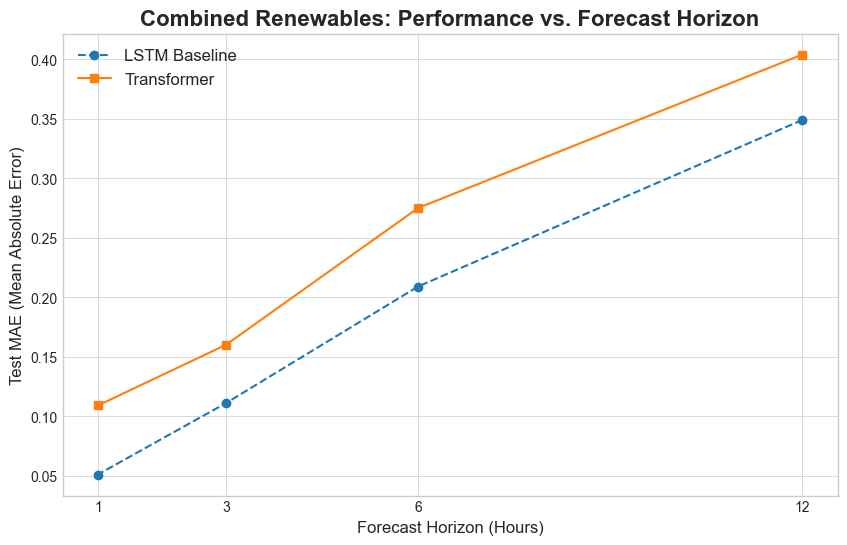


Displaying Plot 2: Solar Only Forecast


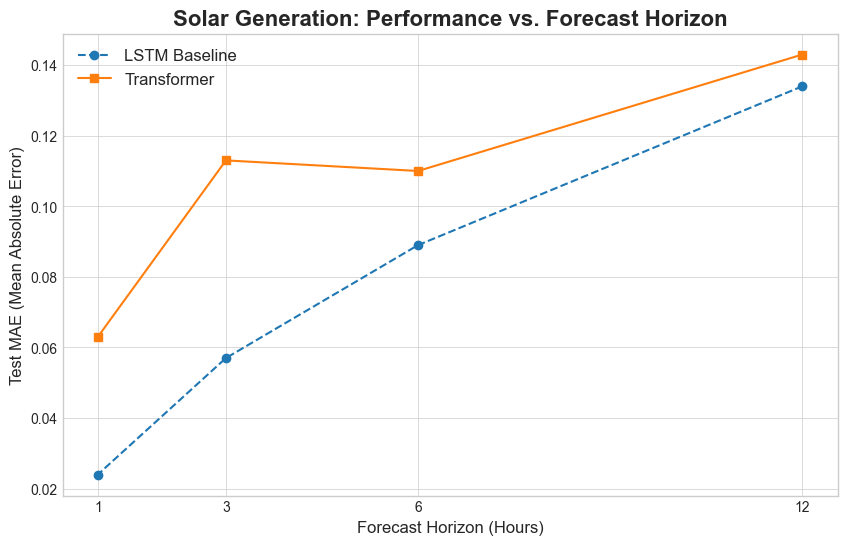


Displaying Plot 3: Wind Only Forecast


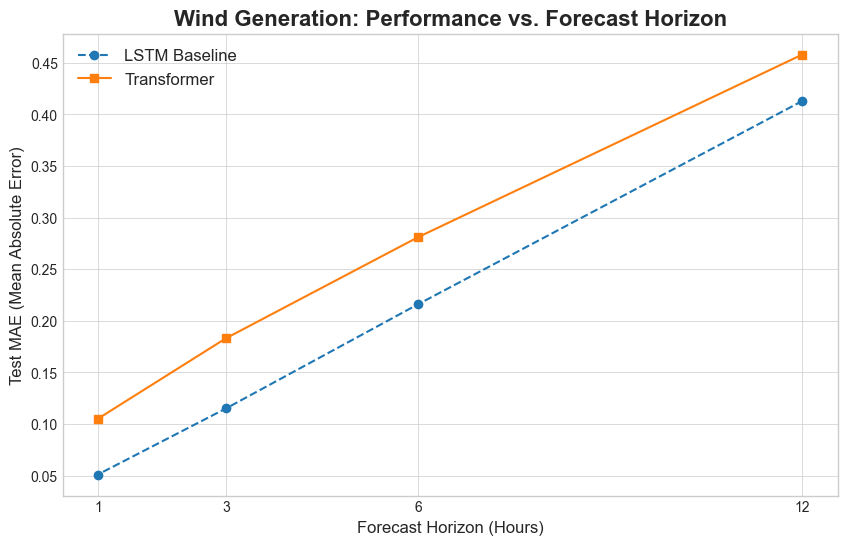


Displaying Plot 4: Performance vs. Lookback Window


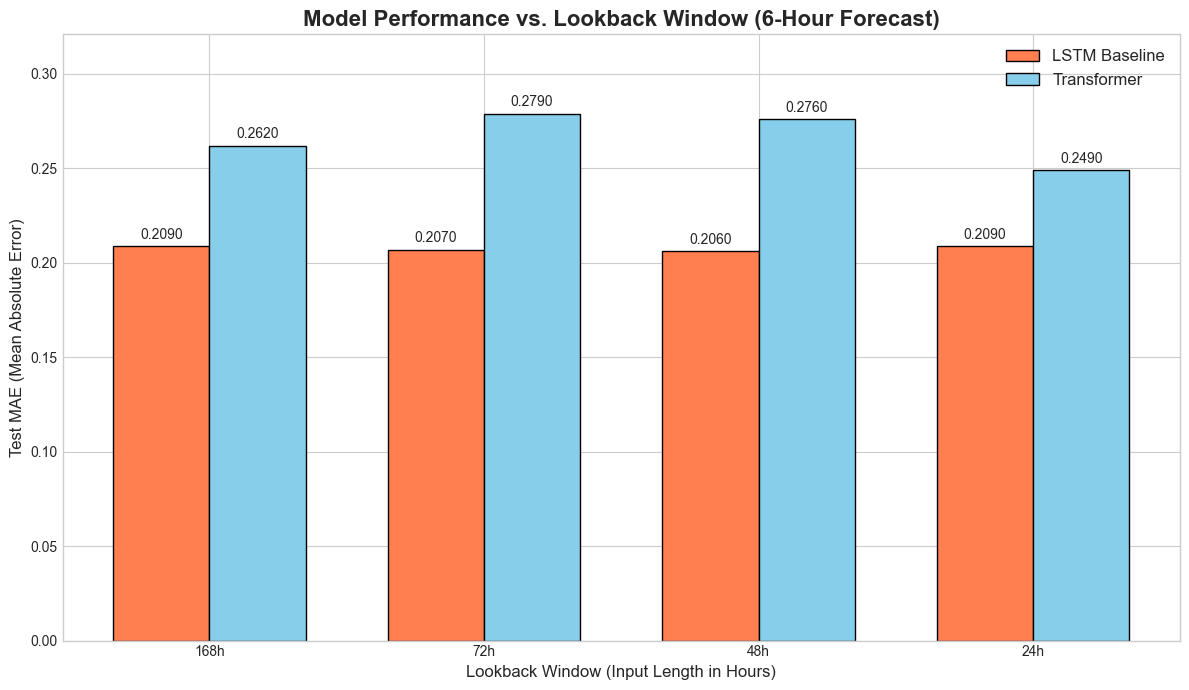


Displaying Plot 5: LSTM Onshore vs. Offshore Wind Performance


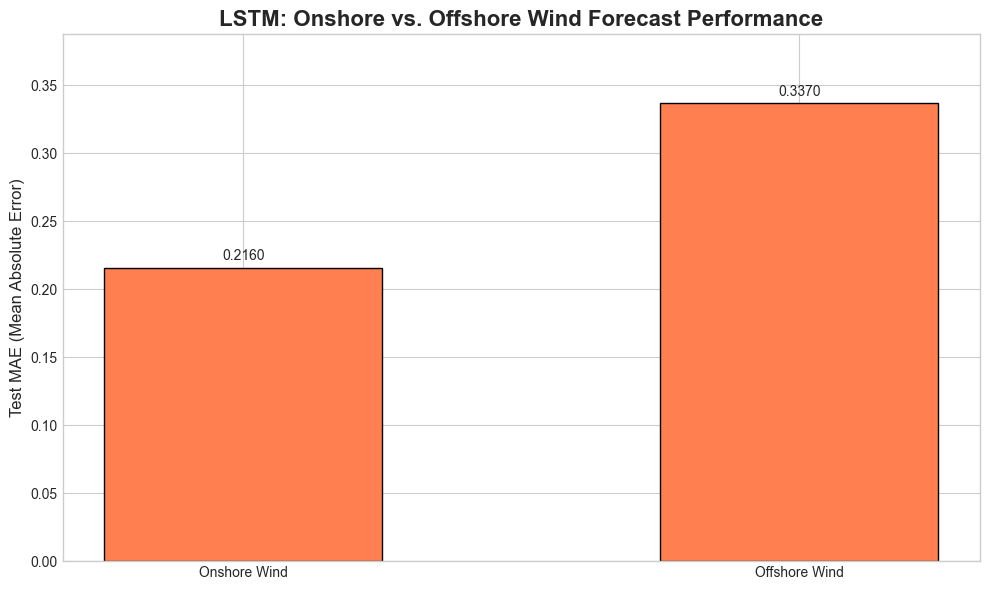

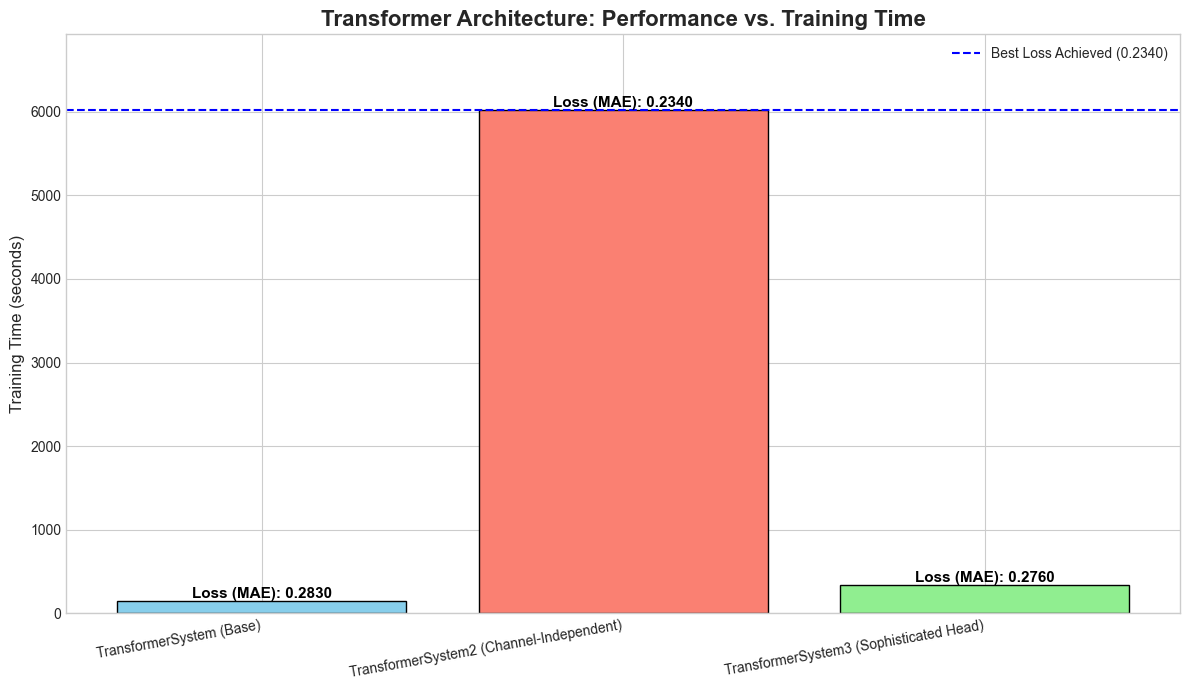

In [19]:
# Use a professional and clean plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# ==============================================================================
# --- Data Section ---
# !!! IMPORTANT: Replace all placeholder lists with your actual final Test MAE scores !!!
# ==============================================================================

# --- Data for Forecast Horizon Plots ---
horizons = [12, 6, 3, 1]

# 1. Combined Forecast Data
combined_lstm_mae = [0.349, 0.209, 0.111, 0.051] 
combined_transformer_mae = [0.404, 0.275, 0.160, 0.109] 

# 2. Solar Only Forecast Data
solar_lstm_mae = [0.134, 0.089, 0.057, 0.024]
solar_transformer_mae = [0.143, 0.110, 0.113, 0.063]

# 3. Wind Only Forecast Data
wind_lstm_mae = [0.413, 0.216, 0.115, 0.051]
wind_transformer_mae = [0.458, 0.281, 0.183, 0.105]

# 4. LSTM Onshore vs Offshore Wind Data
wind_types = ['Onshore Wind', 'Offshore Wind']
lstm_onshore_vs_offshore = [0.216, 0.337]

# --- Data for Lookback Window Plot ---
# This data is for a fixed forecast horizon (e.g., 12 hours) on the combined target
lookbacks = ['168h', '72h', '48h', '24h']
lookback_lstm_mae = [0.209, 0.207, 0.206, 0.209]
lookback_transformer_mae = [0.262, 0.279, 0.276, 0.249]


# ==============================================================================
# Plot 1: Combined Renewables Forecast Performance
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(horizons, combined_lstm_mae, marker='o', linestyle='--', label='LSTM Baseline')
plt.plot(horizons, combined_transformer_mae, marker='s', linestyle='-', label='Transformer')
plt.title('Combined Renewables: Performance vs. Forecast Horizon', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Horizon (Hours)', fontsize=12)
plt.ylabel('Test MAE (Mean Absolute Error)', fontsize=12)
plt.xticks(horizons)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
print("Displaying Plot 1: Combined Renewables Forecast")
plt.show()


# ==============================================================================
# Plot 2: Solar Only Forecast Performance
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(horizons, solar_lstm_mae, marker='o', linestyle='--', label='LSTM Baseline')
plt.plot(horizons, solar_transformer_mae, marker='s', linestyle='-', label='Transformer')
plt.title('Solar Generation: Performance vs. Forecast Horizon', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Horizon (Hours)', fontsize=12)
plt.ylabel('Test MAE (Mean Absolute Error)', fontsize=12)
plt.xticks(horizons)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
print("\nDisplaying Plot 2: Solar Only Forecast")
plt.show()


# ==============================================================================
# Plot 3: Wind Only Forecast Performance
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(horizons, wind_lstm_mae, marker='o', linestyle='--', label='LSTM Baseline')
plt.plot(horizons, wind_transformer_mae, marker='s', linestyle='-', label='Transformer')
plt.title('Wind Generation: Performance vs. Forecast Horizon', fontsize=16, fontweight='bold')
plt.xlabel('Forecast Horizon (Hours)', fontsize=12)
plt.ylabel('Test MAE (Mean Absolute Error)', fontsize=12)
plt.xticks(horizons)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
print("\nDisplaying Plot 3: Wind Only Forecast")
plt.show()


# ==============================================================================
# Plot 4: Model Performance vs. Lookback Window (Grouped Bar Chart)
# ==============================================================================
plt.figure(figsize=(12, 7))
x = np.arange(len(lookbacks))  # the label locations
width = 0.35  # the width of the bars

rects1 = plt.bar(x - width/2, lookback_lstm_mae, width, label='LSTM Baseline', color='coral', edgecolor='black')
rects2 = plt.bar(x + width/2, lookback_transformer_mae, width, label='Transformer', color='skyblue', edgecolor='black')

# Add some text for labels, title and axes ticks
plt.ylabel('Test MAE (Mean Absolute Error)', fontsize=12)
plt.xlabel('Lookback Window (Input Length in Hours)', fontsize=12)
plt.title('Model Performance vs. Lookback Window (6-Hour Forecast)', fontsize=16, fontweight='bold')
plt.xticks(x, lookbacks)
plt.legend(fontsize=12)

# Add the exact MAE value on top of each bar
plt.bar_label(rects1, padding=3, fmt='%.4f')
plt.bar_label(rects2, padding=3, fmt='%.4f')

plt.ylim(0, max(max(lookback_lstm_mae), max(lookback_transformer_mae)) * 1.15)
plt.tight_layout()
print("\nDisplaying Plot 4: Performance vs. Lookback Window")
plt.show()

# ==============================================================================
# Plot 5: LSTM Onshore vs. Offshore Wind Performance
# ==============================================================================
plt.figure(figsize=(10, 6))

# Create a standard bar chart, not a grouped one
rects1 = plt.bar(wind_types, lstm_onshore_vs_offshore, color='coral', edgecolor='black', width=0.5)

# Add some text for labels, title and axes ticks
plt.ylabel('Test MAE (Mean Absolute Error)', fontsize=12)
plt.title('LSTM: Onshore vs. Offshore Wind Forecast Performance', fontsize=16, fontweight='bold')

# Add the exact MAE value on top of each bar
plt.bar_label(rects1, padding=3, fmt='%.4f')

plt.ylim(0, max(lstm_onshore_vs_offshore) * 1.15)
plt.tight_layout()
print("\nDisplaying Plot 5: LSTM Onshore vs. Offshore Wind Performance")
plt.show()

# ==============================================================================
# Plot 6: Transformer Architecture Performances vs. Training Time
# ==============================================================================

# --- Data from your experiments ---
# This dictionary holds the results: {loss: training_time_in_seconds}
results_data = {0.283: 143, 0.234: 6021, 0.276: 336}

# Define the model names corresponding to the results
model_names = ['TransformerSystem (Base)', 'TransformerSystem2 (Channel-Independent)', 'TransformerSystem3 (Sophisticated Head)']
losses = list(results_data.keys())
training_times = list(results_data.values())

# --- Create the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Create the bar chart for training times
bars = ax.bar(model_names, training_times, color=['skyblue', 'salmon', 'lightgreen'], edgecolor='black')

# Add professional labels and title
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('Transformer Architecture: Performance vs. Training Time', fontsize=16, fontweight='bold')
ax.set_xticks(np.arange(len(model_names)))
ax.set_xticklabels(model_names, rotation=10, ha="right")

# Add the loss value as an annotation on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    loss_val = losses[i]
    ax.text(
        bar.get_x() + bar.get_width()/2.0, 
        yval, 
        f'Loss (MAE): {loss_val:.4f}', 
        va='bottom',  # Position text just above the bar
        ha='center',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

# Adjust y-axis to give space for the text labels
ax.set_ylim(0, max(training_times) * 1.15)

# Add a horizontal line for the best loss for easy comparison
best_loss = min(losses)
ax.axhline(y=results_data[best_loss], color='blue', linestyle='--', linewidth=1.5, label=f'Best Loss Achieved ({best_loss:.4f})')
ax.legend()

fig.tight_layout()
plt.show()